# Model 15: Opinion formation

original: https://bookdown.org/amesoudi/ABMtutorial_bookdown/model15.html

### Note

- Salathé & Bonhoeffer (2008) note that many countries suffer disease outbreaks despite ready access to vaccines that prevent those diseases.
    - These outbreaks occur due to the spread of anti-vaccine opinions.
    - These opinions cause people to refuse to vaccinate themselves or their children.
- They assume that anti-vaccine opinions spread via **[social contagion](https://github.com/mas178/social-simulation/blob/main/Mesoudi2021/model13_social_contagion.ipynb) on small-world social networks**.
- They assume that an individual switches opinion from pro- to anti-vaccine, or from anti- to pro-vaccine, with probability equal to the proportion of connected neighbours who have a dissimilar opinion multiplied by a parameter $\Omega$ that determines the strength of opinion formation.
- This is a form of **[unbiased cultural transmission](https://github.com/mas178/social-simulation/blob/main/Mesoudi2021/model01_unbiased_transmission.ipynb) with network constraints**.
    - For example, if pro-vaccine agent $i$ has ten neighbours connected to them via edges in the small world network, and six of those neighbours are anti-vaccine, then when $\Omega = 1$ agent $i$ has a $0.6$ chance of becoming anti-vaccine.
    - When $\Omega = 0.5$ they have a $0.3$ chance of flipping, while if $\Omega = 0$ they never switch opinion.  
- $\Omega$ therefore generates opinion clustering, with groups of like-minded individuals causing individuals with dissimilar opinions to switch to their view.
- Pro-vaccine agents then get vaccinated and become immune, while anti-vaccine agents remain susceptible.
- A single infected agent is introduced at time $t = 0$, and infection is allowed to proceed for $t_{max} = 300$ timesteps.
- Note that this is now disease contagion rather than social contagion.
- The question is: how does opinion clustering, determined by $\Omega$, affect the number of subsequent infections?

In [1]:
using JupyterFormatter
enable_autoformat();

In [2]:
using DataFrames
using Graphs
using GraphPlot
using LinearAlgebra
using Plots
using Random
using StatsBase
using StatsPlots
using Test: @test, @testset

### 1. Generate a small world network (Don't reinvent the wheel.)

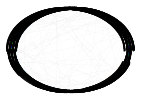

15×15 SparseArrays.SparseMatrixCSC{Int64, Int64} with 120 stored entries:
 ⋅  1  1  1  1  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 1  ⋅  1  1  1  1  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 1  1  ⋅  1  1  1  1  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 1  1  1  ⋅  1  1  1  1  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 1  1  1  1  ⋅  1  1  1  1  1  ⋅  ⋅  ⋅  ⋅  ⋅
 1  1  1  1  1  ⋅  1  1  1  1  1  ⋅  ⋅  ⋅  ⋅
 ⋅  1  1  1  1  1  ⋅  1  1  1  1  1  ⋅  ⋅  ⋅
 ⋅  ⋅  1  1  1  1  1  ⋅  1  1  1  1  1  ⋅  ⋅
 ⋅  ⋅  ⋅  1  1  1  1  1  ⋅  1  1  1  1  1  ⋅
 ⋅  ⋅  ⋅  ⋅  1  1  1  1  1  ⋅  1  1  1  1  1
 ⋅  ⋅  ⋅  ⋅  ⋅  1  1  1  1  1  ⋅  1  1  1  1
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  1  1  1  1  ⋅  1  1  1
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  1  1  1  1  ⋅  1  1
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  1  1  1  1  ⋅  1
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  1  1  1  1  ⋅

In [3]:
N = 2000
k = 10
p = 0.01
g = watts_strogatz(N, k, p)
display(gplot(g, nodelabel = 1:nv(g), layout = circular_layout))
adjacency_matrix(g)[1:15, 1:15]

### 2. Create agents (opinions)

In [4]:
function make_opinions(
    N::Int,     # population size
    c::Float64, # probability of pro-vaccine
)::Vector{Bool}
    # true: pro-vaccine, false: anti-vaccine
    sample([false, true], Weights([1 - c, c]), N)
end;

In [5]:
@testset "make_opinions" begin
    seed = round(Int, time())
    Random.seed!(seed)
    N = 1000
    trials = 1000
    @test mean([count(==(1), make_opinions(N, 0.01)) for _ = 1:trials]) ≈ 10 atol = 0.5
    @test mean([count(==(1), make_opinions(N, 0.1)) for _ = 1:trials]) ≈ 100 atol = 5
    @test mean([count(==(1), make_opinions(N, 0.5)) for _ = 1:trials]) ≈ 500 atol = 10
    @test mean([count(==(1), make_opinions(N, 0.9)) for _ = 1:trials]) ≈ 900 atol = 10
end;

Test Summary: | Pass  Total  Time
make_opinions |    4      4  0.5s


### 3. Get the proportion ($d$) of an agent’s neighbours who have dissimilar opinions to that agent

In [6]:
function get_d_vec(
    network::SimpleGraph,
    opinions::Vector{Bool},
    nodes::Union{UnitRange{Int},Vector{Int}} = 1:length(opinions),
)::Vector{Float64}
    d_s = fill(0.0, length(nodes))

    for i in nodes
        _neighbors = neighbors(network, i)

        # proportion with differing opinions
        d_s[findall(==(i), nodes)] .= mean(opinions[_neighbors] .!= opinions[i])
    end

    d_s
end;

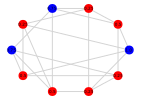

In [7]:
# Quick check
N = 10
k = 4
p = 0.5
c = 0.3
network = watts_strogatz(N, k, p)
opinions = make_opinions(N, c)

# label: d
node_labels = round.(get_d_vec(network, opinions), digits = 2)
# color: pro-vaccine (blue), anti-vaccine (red)
node_colors = [opinion ? "blue" : "red" for opinion in opinions]
gplot(network, nodelabel = node_labels, nodefillc = node_colors, layout = circular_layout)

### 4. Switche opinions

- Next we cycle through each node in random order, and for each focal node $i$, with probability $d_i \Omega$, node $i$ switches opinion.
- Salathé & Bonhoeffer (2008) made the additional assumption that for every agent that switches (e.g. from pro to anti), another agent switches in the opposite direction (e.g from anti to pro).
    - While artificial, this keeps the proportion of pro- and anti-vaccine agents constant.
    - Consequently, we know that any results we find are due to opinion clustering, rather than overall opinion frequency.
    - The code below therefore recalculates $d$ for focal $i$ and its neighbours (this is where having a function get_d is useful), then repeatedly samples another agent with the same opinion as $i$ now has, and with probability $d_j \Omega$ switches $j$ to $i$’s original pre-switch opinion.
    - We then recalculate $d$ in preparation for the next focal.

In [8]:
function switch_opinions!(
    opinions::Vector{Bool},
    d_vec::Vector{Float64},
    network::SimpleGraph,
    Ω::Float64,
)::Nothing
    @assert length(opinions) == length(d_vec)
    Ω == 0.0 && return

    N = length(opinions)

    for i in shuffle(1:N)
        # with prob d*omega
        if rand() < d_vec[i] * Ω
            # i changes its opinion
            opinions[i] = !opinions[i]

            # recalculate d for i and its neighbours
            _neighbors = neighbors(network, i)
            d_vec[_neighbors] .= get_d_vec(network, opinions, _neighbors)

            # get other nodes with the new opinion, excluding self
            same_opinions_index = findall(==(opinions[i]), opinions)
            same_opinions_index = filter(!=(i), same_opinions_index)

            for _ = 1:10^3
                j = rand(same_opinions_index)

                if rand() < d_vec[j] * Ω
                    # j changes its opinion
                    opinions[j] = !opinions[j]

                    # recalculate d for i and its neighbours
                    _neighbors = neighbors(network, j)
                    d_vec[_neighbors] .= get_d_vec(network, opinions, _neighbors)

                    break
                end
            end
        end
    end

    return
end;

In [9]:
@testset "switch_opinions!" begin
    N = 1000
    k = 4
    p = 0.5
    c = 0.3
    Ω = 0.1
    network = watts_strogatz(N, k, p)
    opinions = make_opinions(N, c)
    d_vec = get_d_vec(network, opinions)

    # previous status
    prev_opinions = copy(opinions)
    prev_d_vec = copy(d_vec)

    switch_opinions!(opinions, d_vec, network, Ω)

    @test prev_opinions != opinions
    @test mean(prev_opinions) == mean(opinions)
    @test prev_d_vec != d_vec
end;

Test Summary:    | Pass  Total  Time
switch_opinions! |    3      3  0.2s


### 5. Vaccination and infecttion

In [10]:
function make_agents(N::Int)::Vector{String}
    fill("S", N)
end

function vaccination!(agents::Vector{String}, opinions::Vector{Bool})::Nothing
    agents[opinions] .= "R"
    return
end

function infecttion!(agents::Vector{String})::Nothing
    agents_S_idx = findall(==("S"), agents)
    isempty(agents_S_idx) && return

    agents[rand(agents_S_idx)] = "I"
    return
end

function infecttion!(agents::Vector{String}, network::SimpleGraph, β::Float64)::Int64
    agents_S_idx = findall(==("S"), agents)
    isempty(agents_S_idx) && return 0

    all_neighbors = map(i -> neighbors(network, i), agents_S_idx)
    infected_neighbours_count = map(n -> count(==("I"), agents[n]), all_neighbors)

    # probability of infection
    prob_infection = 1.0 .- exp.((-β) * infected_neighbours_count)

    # probability to compare
    prob = rand(length(agents_S_idx))

    # S agents are infected with prob_infection
    agents[agents_S_idx[prob.<prob_infection]] .= "I"

    return sum(prob .< prob_infection)
end

function recovery!(agents::Vector{String}, γ::Float64)::Int64
    agents_I_idx = findall(==("I"), agents)
    isempty(agents_I_idx) && return 0

    prob = rand(length(agents_I_idx))
    agents[agents_I_idx[prob.<γ]] .= "R"

    return sum(prob .< γ)
end;

In [11]:
@testset "vaccination!" begin
    N = 1000
    c = 0.3
    opinions = make_opinions(N, c)
    agents = make_agents(N)
    prev_agents = copy(agents)
    vaccination!(agents, opinions)
    @test prev_agents != agents
    @test (prev_agents .!= agents) == opinions
end

@testset "infecttion!1" begin
    N = 1000

    # 全員 "S" の場合
    agents = make_agents(N)
    prev_agents = copy(agents)
    infecttion!(agents)
    @test prev_agents != agents
    @test sum(prev_agents .!= agents) == 1

    # 全員 "I" の場合
    agents .= fill("I", N)
    prev_agents = copy(agents)
    infecttion!(agents)
    @test prev_agents == agents


    # "S" と "I" が混ざってる場合
    agents .= rand(["S", "I"], N)
    prev_agents = copy(agents)
    infecttion!(agents)
    @test prev_agents != agents
    @test sum(prev_agents .!= agents) == 1
end

@testset "infecttion!2" begin
    N = 2000
    k = 10
    p = 0.01
    β = 0.05
    network = watts_strogatz(N, k, p)
    agents = rand(["S", "I", "R"], N)

    prev_agents = copy(agents)
    infected_count = infecttion!(agents, network, β)
    @test prev_agents != agents
    @test sum(prev_agents .!= agents) == infected_count
    @show infected_count
end

@testset "recovery!" begin
    N = 1000
    agents = rand(["S", "I"], N)
    prev_agents = copy(agents)

    recovered_count = recovery!(agents, 0.1)

    @test prev_agents != agents
    @test sum(prev_agents .!= agents) == recovered_count
end

Test Summary: | Pass  Total  Time
vaccination!  |    2      2  0.1s
Test Summary: | Pass  Total  Time
infecttion!1  |    5      5  0.1s
infected_count = 88
Test Summary: | Pass  Total  Time
infecttion!2  |    2      2  0.2s
Test Summary: | Pass  Total  Time
recovery!     |    2      2  0.1s


Test.DefaultTestSet("recovery!", Any[], 2, false, false, true, 1.68258194115842e9, 1.682581941222637e9)

### 6. Run all

In [12]:
function opinion_formation(;
    N::Int = 2000,     # population size
    k::Int = 10,       # initianl network degree
    p::Float64 = 0.01, # probability to rewire in making small world network
    c::Float64 = 0.5,  # probability of pro-vaccine
    Ω::Float64 = 1.0,  # strength of opinion clustering
    β::Float64 = 0.05,
    γ::Float64 = 0.1,
    generations::Int = 300, # time steps (generation)
    trials::Int = 100,      # trial count
)::Vector{Int}
    outputs = fill(0, trials)

    for trial = 1:trials
        network = watts_strogatz(N, k, p)
        opinions = make_opinions(N, c)
        agents = make_agents(N)
        d_vec = get_d_vec(network, opinions)

        switch_opinions!(opinions, d_vec, network, Ω)
        vaccination!(agents, opinions)
        infecttion!(agents)

        for _ = 1:generations
            outputs[trial] += infecttion!(agents, network, β)
            recovery!(agents, γ)
        end
    end

    return outputs
end;

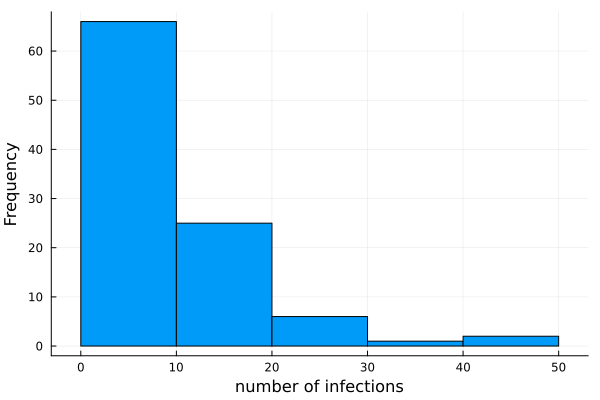

In [13]:
outputs = opinion_formation()
histogram(
    outputs,
    bins = Int(ceil(maximum(outputs) / 10)),
    xlabel = "number of infections",
    ylabel = "Frequency",
    legend = false,
)

In [14]:
prop_outbreak = sum(outputs .>= 10) ./ length(outputs)
println("mean number of infections: $(mean(outputs))")
println("proportion of outbreaks (infections >= 10): $(prop_outbreak)")

mean number of infections: 7.97
proportion of outbreaks (infections >= 10): 0.34


In [15]:
c_values = 0.5:0.05:0.95
Ω_values = [0.0, 1.0]
outputs = DataFrame(Ω = Int[], c = Int[], outbreak_probability = Float64[])

for Ω in Ω_values
    for c in c_values
        infection_count_vec = opinion_formation(c = c, Ω = Ω)
        outbreak_count = count(>=(10), infection_count_vec)
        push!(
            outputs,
            [Int(Ω), Int(round(c * 100)), outbreak_count / length(infection_count_vec)],
        )
    end
end

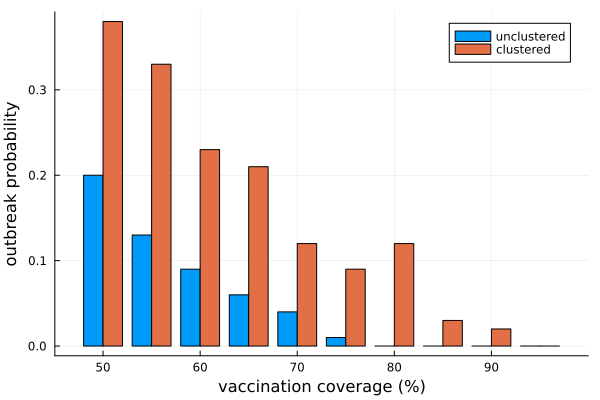

In [16]:
@df outputs groupedbar(
    :c,
    :outbreak_probability,
    group = :Ω,
    xlabel = "vaccination coverage (%)",
    ylabel = "outbreak probability",
    label = ["unclustered" "clustered"],
)

- This model combined the following models to explore the effect of vaccine-related opinion clustering on the spread of diseases.
    - unbiased transmission (Model 1),
    - SIR contagion models (Model 13) and
    - small world social networks (Model 14)
- Agents switch opinion, from pro- to anti-vaccine or anti- to pro-vaccine, in proportion to the number of neighbours who have dissimilar opinions, a form of unbiased cultural transmission.
- 意見のクラスタリングが強い場合 ($\Omega = 1$: オレンジ色のバー) の方が、クラスタリングが弱い ($\Omega = 0$: ブルーのバー) 場合よりもアウトブレイクが起こりやすい。
- ワクチン接種率 ($c$) が高いほど、アウトブレイクは起こりにくい。
- This finding has implications for controlling diseases for which vaccines are available.
- This is a timely topic given the global covid pandemic, as well as previous outbreaks caused by vaccine refusal such as MMR in the UK.
    - People do not get their opinions from random others.
    - They get them from their friends, family, neighbours and work colleagues.
    - This generates self-reinforcing clusters of anti-vaccine opinions, and consequently disease outbreaks.
    - Spending billions of pounds on vaccine development is pointless if anti-vaccine opinions mean that large clusters of people refuse to take it.
- Models like Salathé & Bonhoeffer’s are important for suggesting interventions that might prevent opinion clustering, or break up clusters that have already formed.